Using device: cpu


Epoch 1/4: 100%|██████████| 938/938 [06:09<00:00,  2.54it/s]


Epoch 1/4, Average Loss: 0.0867


Epoch 2/4: 100%|██████████| 938/938 [05:34<00:00,  2.80it/s]


Epoch 2/4, Average Loss: 0.0457


Epoch 3/4: 100%|██████████| 938/938 [05:25<00:00,  2.88it/s]


Epoch 3/4, Average Loss: 0.0409


Epoch 4/4: 100%|██████████| 938/938 [05:33<00:00,  2.82it/s]


Epoch 4/4, Average Loss: 0.0387
Training completed.
Generating specific images...
Generated images saved as 'generated_specific_images.png'


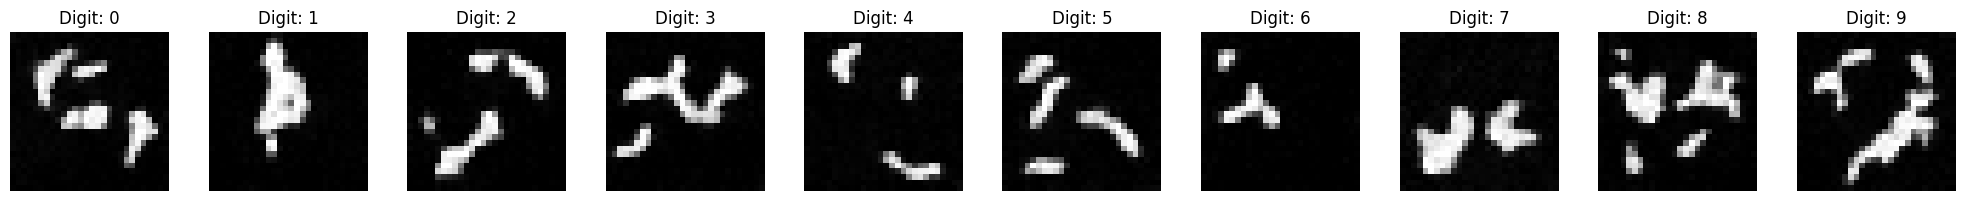

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt


class ConditionalSimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(ConditionalSimpleUNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels + num_classes + 1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, out_channels, 3, padding=1)

    def forward(self, x, t, c):
        t = t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        t = t.expand(-1, 1, x.shape[2], x.shape[3])
        c = c.unsqueeze(-1).unsqueeze(-1)
        c = c.expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, t, c], dim=1)

        x1 = F.relu(self.conv1(x))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.upsample(x2)
        x4 = F.relu(self.conv3(x3 + x1))
        return self.conv4(x4)


class ConditionalDiffusionModel:
    def __init__(
        self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, num_classes=10
    ):
        self.num_timesteps = num_timesteps
        self.beta = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.num_classes = num_classes

        self.model = ConditionalSimpleUNet(
            in_channels=1, out_channels=1, num_classes=num_classes
        )

    def forward_diffusion(self, x0, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[
            :, None, None, None
        ]
        epsilon = torch.randn_like(x0)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * epsilon, epsilon

    def train_step(self, x0, c, optimizer):
        optimizer.zero_grad()
        t = torch.randint(0, self.num_timesteps, (x0.shape[0],), device=x0.device)
        x_t, epsilon = self.forward_diffusion(x0, t)
        predicted_noise = self.model(x_t, t.float() / self.num_timesteps, c)
        loss = F.mse_loss(epsilon, predicted_noise)
        loss.backward()
        optimizer.step()
        return loss.item()

    @torch.no_grad()
    def sample(self, num_samples, image_size, condition):
        device = next(self.model.parameters()).device
        x = torch.randn(num_samples, 1, image_size, image_size, device=device)
        c = F.one_hot(condition, num_classes=self.num_classes).float().to(device)

        for t in range(self.num_timesteps - 1, -1, -1):
            t_tensor = torch.full((num_samples,), t, dtype=torch.long, device=device)
            predicted_noise = self.model(x, t_tensor.float() / self.num_timesteps, c)
            alpha_t = self.alpha[t]
            alpha_bar_t = self.alpha_bar[t]
            beta_t = self.beta[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = (
                1
                / torch.sqrt(alpha_t)
                * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * predicted_noise)
                + torch.sqrt(beta_t) * noise
            )
        return x


# Data loading
def get_data_loader(batch_size=64):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    dataset = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Training loop
def train(diffusion, train_loader, num_epochs=10, device="cpu"):
    optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=1e-3)
    diffusion.model.to(device)

    for epoch in range(num_epochs):
        total_loss = 0
        for batch, (images, labels) in enumerate(
            tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        ):
            images = images.to(device)
            c = F.one_hot(labels, num_classes=diffusion.num_classes).float().to(device)
            loss = diffusion.train_step(images, c, optimizer)
            total_loss += loss

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

    print("Training completed.")


# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    diffusion = ConditionalDiffusionModel()
    train_loader = get_data_loader()

    # Train the model
    train(diffusion, train_loader, num_epochs=1, device=device)

    # Generate specific images
    print("Generating specific images...")
    num_samples = 10
    image_size = 28

    # Generate one image for each digit (0-9)
    conditions = torch.arange(10, device=device)
    samples = diffusion.sample(
        num_samples=num_samples, image_size=image_size, condition=conditions
    )

    # Visualize the generated samples
    samples = samples.cpu().squeeze(1)
    samples = (samples + 1) / 2
    samples = samples.clamp(0, 1)

    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap="gray")
        ax.set_title(f"Digit: {i}")
        ax.axis("off")

    plt.tight_layout()
    plt.savefig("generated_specific_images.png")
    print("Generated images saved as 'generated_specific_images.png'")
    plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleUNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, out_channels, 3, padding=1)

    def forward(self, x, t):
        t = t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # Add three dimensions
        t = t.expand(-1, 1, x.shape[2], x.shape[3])  # Expand t to match x's spatial dimensions
        x = torch.cat([x, t], dim=1)

        x1 = F.relu(self.conv1(x))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.upsample(x2)
        x4 = F.relu(self.conv3(x3 + x1))
        return self.conv4(x4)

class DiffusionModel:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.num_timesteps = num_timesteps
        self.beta = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

        self.model = SimpleUNet(in_channels=2, out_channels=1)

    def forward_diffusion(self, x0, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        epsilon = torch.randn_like(x0)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * epsilon, epsilon

    def train_step(self, x0, optimizer):
        optimizer.zero_grad()
        t = torch.randint(0, self.num_timesteps, (x0.shape[0],), device=x0.device)
        x_t, epsilon = self.forward_diffusion(x0, t)
        predicted_noise = self.model(x_t, t.float() / self.num_timesteps)
        loss = F.mse_loss(epsilon, predicted_noise)
        loss.backward()
        optimizer.step()
        return loss.item()

    @torch.no_grad()
    def sample(self, num_samples, image_size):
        device = next(self.model.parameters()).device
        x = torch.randn(num_samples, 1, image_size, image_size, device=device)
        for t in range(self.num_timesteps - 1, -1, -1):
            t_tensor = torch.full((num_samples,), t, dtype=torch.long, device=device)
            predicted_noise = self.model(x, t_tensor.float() / self.num_timesteps)
            alpha_t = self.alpha[t]
            alpha_bar_t = self.alpha_bar[t]
            beta_t = self.beta[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = (
                1
                / torch.sqrt(alpha_t)
                * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * predicted_noise)
                + torch.sqrt(beta_t) * noise
            )
        return x

In [10]:
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset


# Custom dataset loading
def load_custom_dataset(file_path, batch_size=64):
    # Load the .npz file
    data = np.load(file_path)

    # Assuming the .npz file contains a key 'images' for the image data
    # Modify this key if your .npz file uses a different key
    images = data["images"]

    # Normalize the images to [-1, 1] range
    images = (images / 127.5) - 1

    # Convert to torch tensors
    images_tensor = torch.FloatTensor(images).unsqueeze(1)  # Add channel dimension

    # Create a TensorDataset
    dataset = TensorDataset(images_tensor)

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader


# Training loop with improved progress indication
def train(diffusion, train_loader, num_epochs=10, device="cpu"):
    optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=1e-3)
    diffusion.model.to(device)

    total_batches = len(train_loader)
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_loss = 0
        with tqdm(
            total=total_batches, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"
        ) as pbar:
            for batch, (images) in enumerate(train_loader):
                images = images.to(device)
                loss = diffusion.train_step(images, optimizer)
                epoch_loss += loss

                # Update progress bar
                pbar.update(1)
                pbar.set_postfix(
                    {
                        "Loss": f"{loss:.4f}",
                        "Avg Loss": f"{epoch_loss / (batch + 1):.4f}",
                    }
                )

        avg_epoch_loss = epoch_loss / total_batches
        elapsed_time = time.time() - start_time

        print(f"Epoch {epoch+1}/{num_epochs} completed.")
        print(f"Average Loss: {avg_epoch_loss:.4f}")
        print(f"Time Elapsed: {elapsed_time:.2f} seconds")
        print(
            f"Estimated Time Remaining: {elapsed_time * (num_epochs - epoch - 1) / (epoch + 1):.2f} seconds"
        )
        print("-" * 50)

    print("Training completed.")
    print(f"Total training time: {time.time() - start_time:.2f} seconds")


# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load custom dataset
    npz_file_path = "../data8.npz"  # Replace with your .npz file path
    train_loader = load_custom_dataset(npz_file_path, batch_size=64)

    # Initialize the diffusion model
    # Adjust in_channels if your images have more than one channel
    diffusion = DiffusionModel()
    diffusion.model = SimpleUNet(in_channels=2, out_channels=1)  # Adjust if necessary

    # Train the model
    train(diffusion, train_loader, num_epochs=10, device=device)

    # Generate samples
    print("Generating samples...")
    num_samples = 16
    image_size = train_loader.dataset.tensors[0].shape[2]  # Assuming square images
    samples = diffusion.sample(num_samples=num_samples, image_size=image_size).cpu()

    # Visualize the generated samples
    samples = samples.squeeze(1)  # Remove the channel dimension
    samples = (samples + 1) / 2  # Rescale from [-1, 1] to [0, 1]
    samples = samples.clamp(0, 1)  # Ensure values are in [0, 1] range

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i], cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    plt.suptitle("Generated Images", fontsize=16)
    plt.subplots_adjust(top=0.95)  # Adjust to make room for the title

    # Save the figure
    plt.savefig("generated_images.png")
    print("Generated images saved as 'generated_images.png'")

    # Optionally, display the plot (comment out if running on a server without display)
    plt.show()


Using device: cpu


Epoch 1/10:   0%|          | 0/860 [00:00<?, ?batch/s]


AttributeError: 'list' object has no attribute 'to'